# Report: Kameneva Lab Data Analysis Task

#### Preamble

I have chosen to work on the tasks using `Python` as it is the programming language I am most capable with.
As you will see, my results do not fully align with the analyses carried out in the Nature publication and I am thinking
that might at least be in part be due to differences in `R` and `Pyhton` package availability and implementations and differences in the preprocessing of the data.

#### Abstract

In this analysis, tissue samples from human embryos spanning developmental weeks 6 to 14 were examined using single-cell RNA sequencing to investigate adrenal gland development. While not all findings from Kameneva et al. could be fully reproduced—such as transitions connecting the intermediate mesoderm with progenitors of various organ systems—the focused analysis of intra-adrenal samples is largely consistent with the published results. Specifically, Schwann cell precursors (SCPs) were found to differentiate into both sympathoblasts and chromaffin cells, supporting the proposed fork-like origin of adrenal medulla cells. Additionally, trajectory analysis revealed a transcriptional continuum suggesting a possible transition or shared intermediate state between sympathoblasts and chromaffin cells. 

These observations highlight the plasticity of early adrenal progenitors and underscore the importance of transcriptional dynamics in lineage specification, having potential implications for understanding cellular origins and early development.

## Preprocessing

In [2]:
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import numpy as np
import os

# sc.settings.verbosity = 2

In [ ]:
data_dir = "./data/raw/"
h5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".h5")]

### Filter

In [5]:
samples = {}

for h5_file in h5_files:
    basename = os.path.basename(h5_file)
    sample_id = basename.split(".")[0].split("_")[-1]
    samples[sample_id] = h5_file

Usually I would filter for hemoglobing and ribosomal genes, but I prioritized sticking the publications preprocessing which only mentioned removal of >25% mitochondrial genes and filtering for a minimum and maximum of genes.

In [ ]:
for ix, (sample_id, filename) in enumerate(samples.items()):
    print(f"Processing file {ix + 1}/{len(samples)}: {sample_id}")

    sample_adata = sc.read_10x_h5(filename)
    sample_adata.var_names_make_unique()

    # filter for genes
    sc.pp.filter_cells(sample_adata, min_genes=200)
    sc.pp.filter_cells(sample_adata, max_genes=7000)

    # filter for more than 25% mitochondrial genes
    sample_adata.var["mt"] = sample_adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(sample_adata, qc_vars="mt", inplace=True, log1p=True)
    sample_adata = sample_adata[sample_adata.obs.pct_counts_mt < 25, :]
    
    # store the filtered data
    filtered_dir = "./data/filtered/"
    basename = os.path.basename(filename)
    basename = os.path.splitext(basename)[0]
    filtered_file = os.path.join(filtered_dir, f"{basename}_filtered.h5ad")
    sample_adata.write_h5ad(filtered_file)

### Combine

I am doing this in two steps because I only have 12GB RAM available and my kernel kept dying.

In [42]:
filtered_data_dir = "./data/filtered"
filtered_h5_files = [os.path.join(filtered_data_dir, f) for f in os.listdir(filtered_data_dir) if f.endswith(".h5ad")]

In [43]:
samples = {}

for h5_file in filtered_h5_files:
    basename = os.path.basename(h5_file)
    sample_id = basename.split(".")[0].split("_")[-1]
    samples[sample_id] = h5_file

In [ ]:
adatas = {}

for ix, (sampled_id, filename) in enumerate(samples.items()):

    sample_adata = sc.read_h5ad(filename)
    sample_adata.var_names_make_unique()

    adatas[sampled_id] = sample_adata

# concatenate using outer to keep all genes and samples
adata = ad.concat(adatas, join="outer", label="sample")

combined_file = os.path.join(filtered_data_dir, "combined_filtered.h5ad")
adata.write_h5ad(combined_file)

The combined data set leaves us with **146,273** cells.

### Feature Selection

2000 genes were chosen in accordance with the Methods section of the paper.

In [2]:
adata = sc.read_h5ad('/home/enno/code/scAnalysis/data/merged/combined_filtered.h5ad')
adata.obs_names_make_unique()

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True, flavor="seurat_v3", subset=True, batch_key="sample")

### Regress out counts, percent mitochondrial and cell cycle 

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [5]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

Here we are regressing out cell cylce scores to remove variation caused by proliferative states, which can obscure true biological signals and lead to artificial clustering of cells by cell cycle phase rather than by cell type or developmental trajectory.

In [6]:
# Inspired by the scanpy usage example:
# https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

       'DTL', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1',
       'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'RAD51',
       'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1',
       'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'],
      dtype='object')
       'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'CDCA2', 'PSRC1', 'LBR',
       'CKAP5', 'CTCF', 'G2E3', 'GAS2L3', 'CBX5'],
      dtype='object')


In [ ]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

In [ ]:
# store as h5ad
adata.write_h5ad('./data/merged/cleaned.h5ad')

## Cluster Analysis

This section deals with Tasks 2, 3, and 4 of the assignment.

In [3]:
adata = sc.read_h5ad('data/merged/cleaned.h5ad')

### PCA

[<Axes: title={'center': 'phase'}, xlabel='PC1', ylabel='PC2'>,
 <Axes: title={'center': 'sample'}, xlabel='PC1', ylabel='PC2'>]

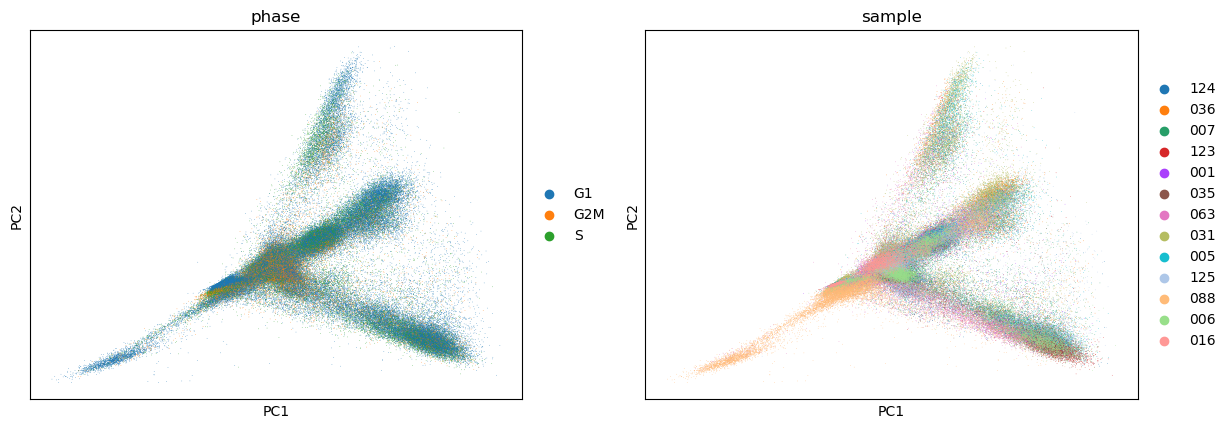

In [4]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color=['phase', 'sample'], use_raw=False, show=False)

PCA plot of the data color coded by cell cylce phase (left) and sample id (right). We see that the cell cylce phase is not a driving factor in the variance of the data.

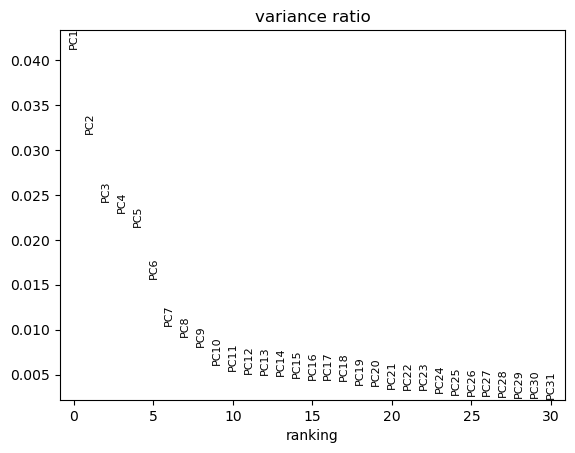

In [5]:
# Variance ratio plot
sc.pl.pca_variance_ratio(adata, log=False, show=False)

... however this has to be taken with a grain of salt as only baout 7% of variance is explained through the first two Principle Components.

### UMAP

In [ ]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)
sc.tl.umap(adata)

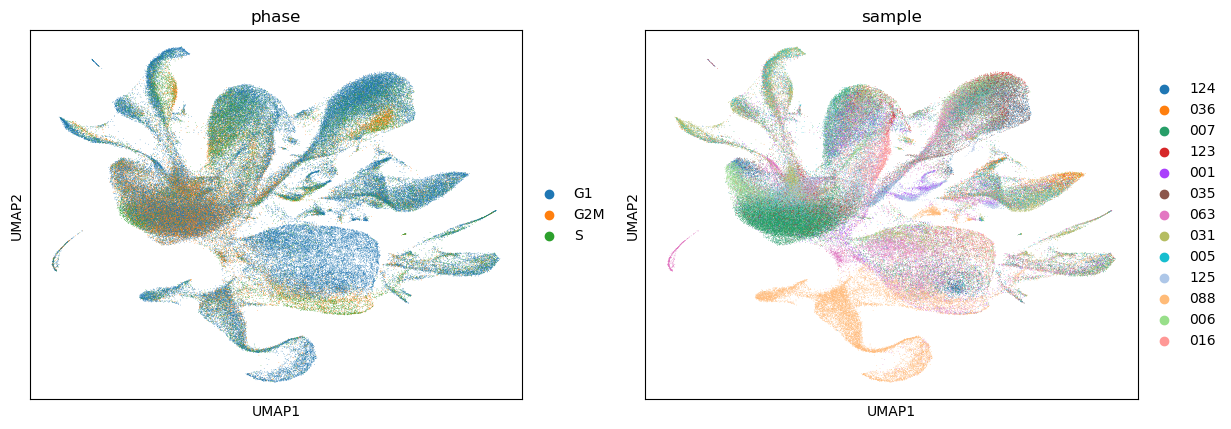

In [7]:
sc.pl.umap(adata, color=['phase', 'sample'], use_raw=False)

This figure shows two UMAP visualizations of single-cell RNA-seq data after cell cycle regression. In the left panel, cells are colored by cell cycle phase (G1, S, G2M). While large regions display a good mix of phases—indicating that cell cycle regression was at least partially effective—some areas still appear to be influenced by cell cycle state. In the right panel, cells are colored by sample ID. Although many clusters contain cells from multiple samples, some regions are still dominated by specific samples. This is expected, as the samples represent different developmental stages, and certain cell types or states may be unique to specific time points. Overall, the cell cycle regression appears to have reduced confounding effects, while sample-specific variation likely reflects meaningful biological differences across development.

### Clustering

In [8]:
# clustering
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=15)
sc.tl.leiden(adata, flavor="igraph", resolution=0.3)

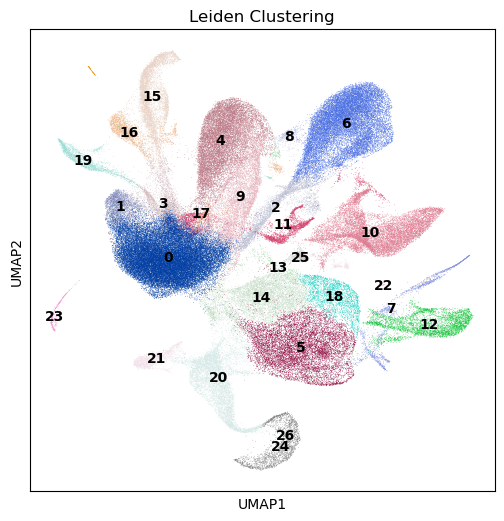

In [9]:
fig = sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10, return_fig=True, title='Leiden Clustering')
fig.set_size_inches(6, 6)

This UMAP visualization shows the distribution of Leiden clusters across the dataset. Many of the clusters correspond well to distinct aggregations of cells in the UMAP, indicating that the clustering captures meaningful transcriptional differences. However, there are also instances where a single UMAP cluster is split into multiple Leiden clusters. These cases may represent over-clustering, where transcriptionally similar cells have been assigned to separate groups. Such clusters could potentially be combined in downstream analyses to better reflect underlying biology. To further interpret these clusters, we next examine the expression of marker genes previously identified in the paper, mapping them onto the UMAP to assess how well our clusters align with the identified cell types.

### Marker Gene Expression

In [ ]:
# genes taken from the Kamenve et al. Figure 1
genes = {
    "Endothelum": ["PECAM1", "KDR"],
    "Subepicardial and abdominal mesenchyme": ["PRRX1"],
    "Intermediate mesoderm": ["GATA4", "HAND2"],
    "Liver": ["HNF4A", "AHSG"],
    "HSCs": ["SPINK2", "AZU1"],
    "Immune cells": ["FCGR1A", "CD163"],
    "Erythroid cells": ["HBA2", "HBB"],
    "Melanocytes": ["MITF"],
    "Kidney": ["PAX2"],
    "Adrenal gland cortex": ["NR5A1"],
    "SCPs": ["SOX10", "PLP1", "FOXD3"],
    "Chromaffin cells": ["ELAVL3", "ELAVL4", "PHOX2B", "TH"],
    "Symphatoblasts": ["STMN2"]
}

for category, gene_list in genes.items():
    for gene in gene_list:
        is_in_data = gene in adata.var_names

        # filter genes that are not in the data
        if not is_in_data:
            print(f"{gene} ({category}) not in data")
            gene_list.remove(gene)
            continue

GATA4 (Intermediate mesoderm) not in data
HNF4A (Liver) not in data
FCGR1A (Immune cells) not in data
ELAVL3 (Chromaffin cells) not in data


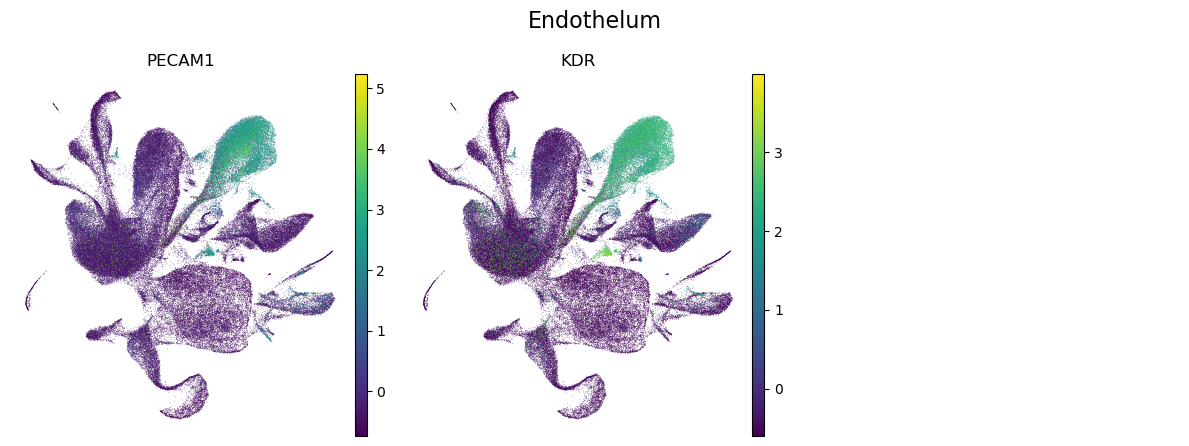

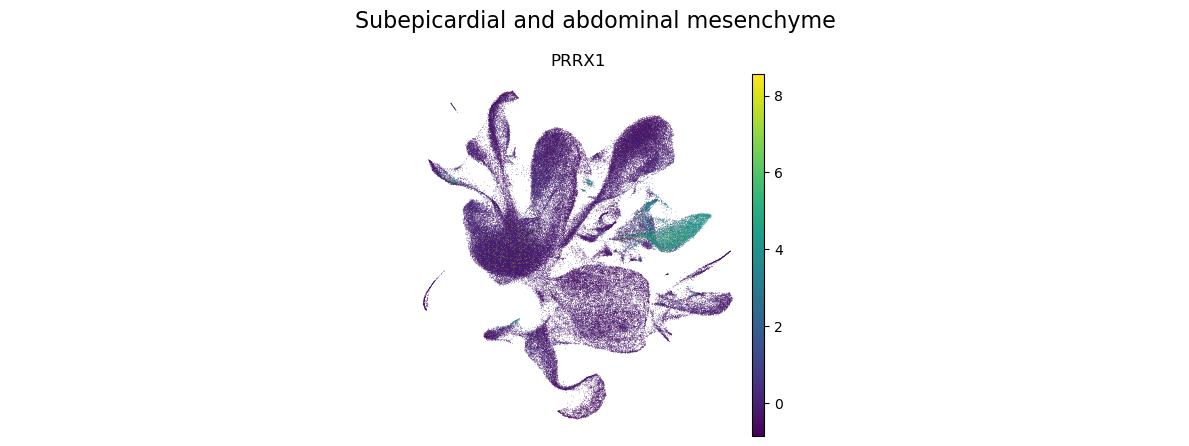

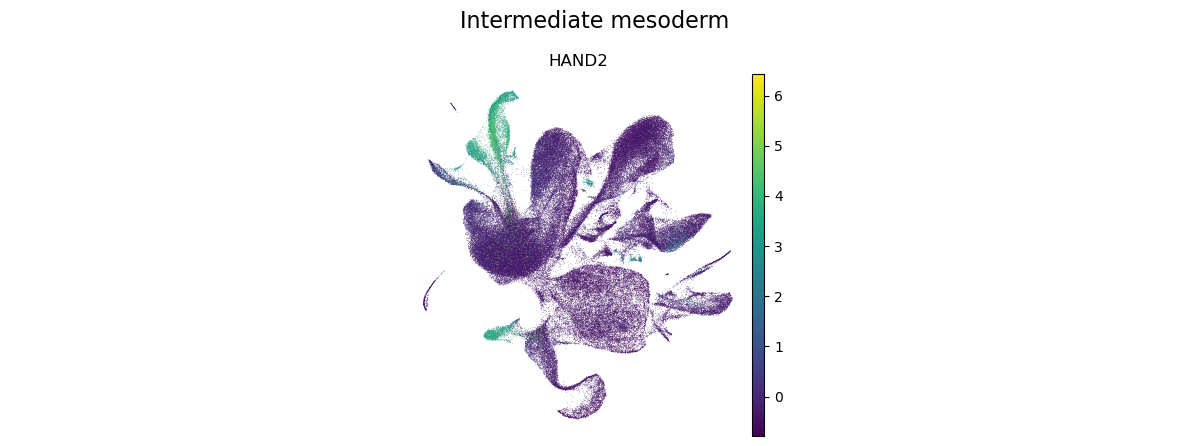

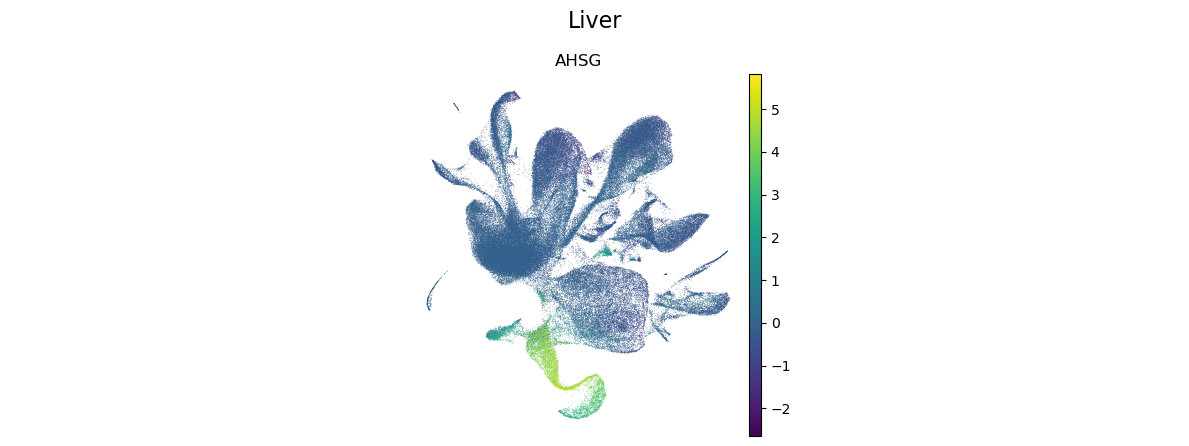

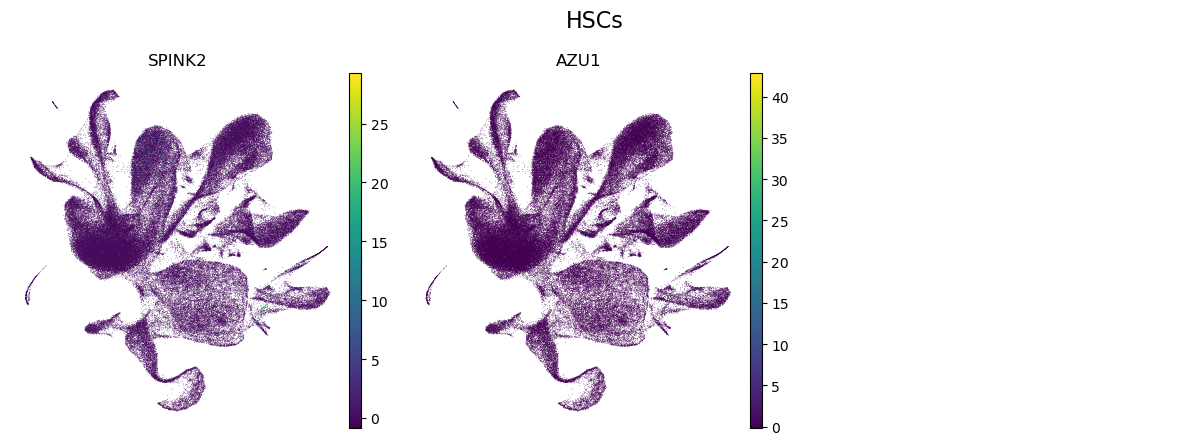

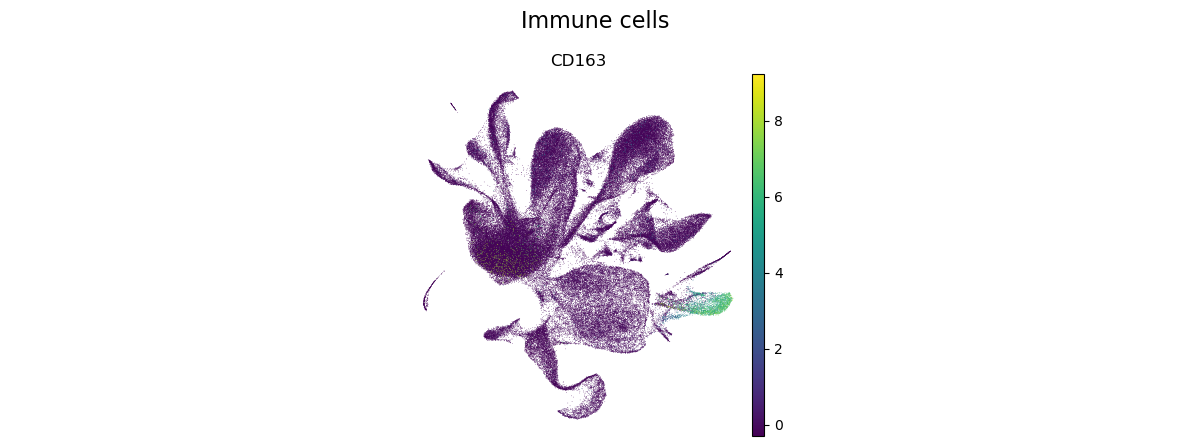

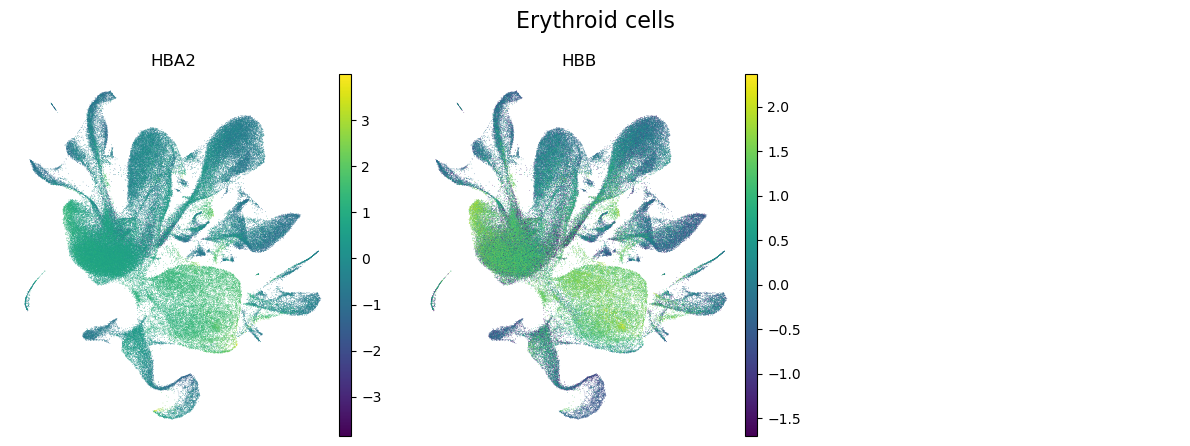

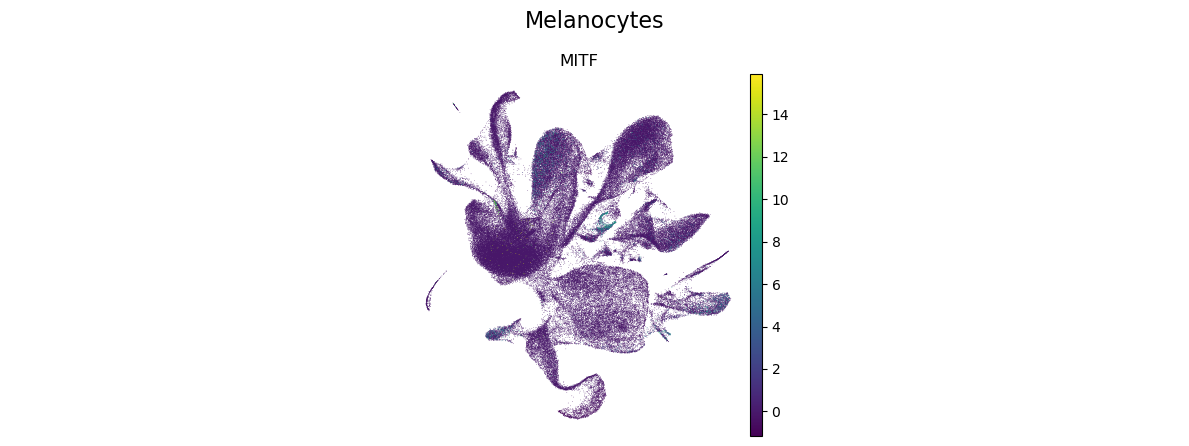

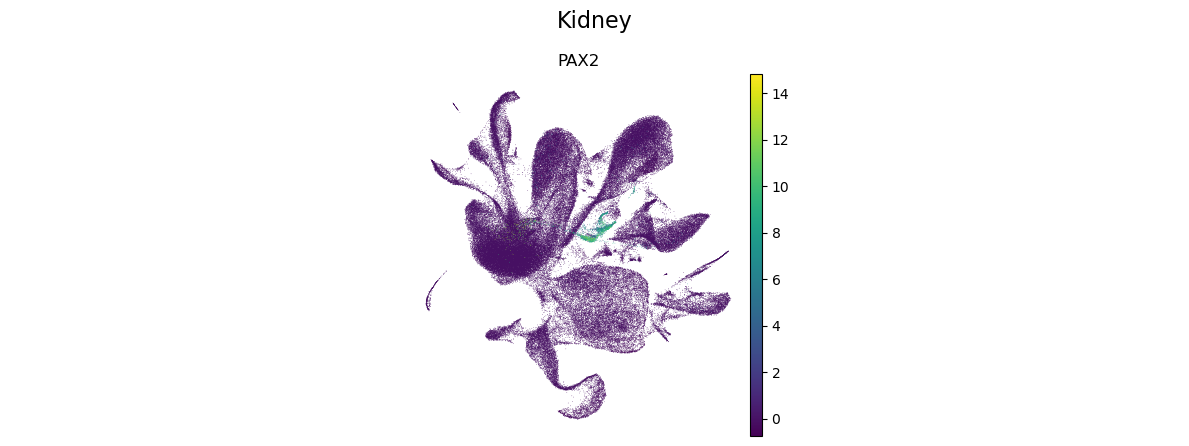

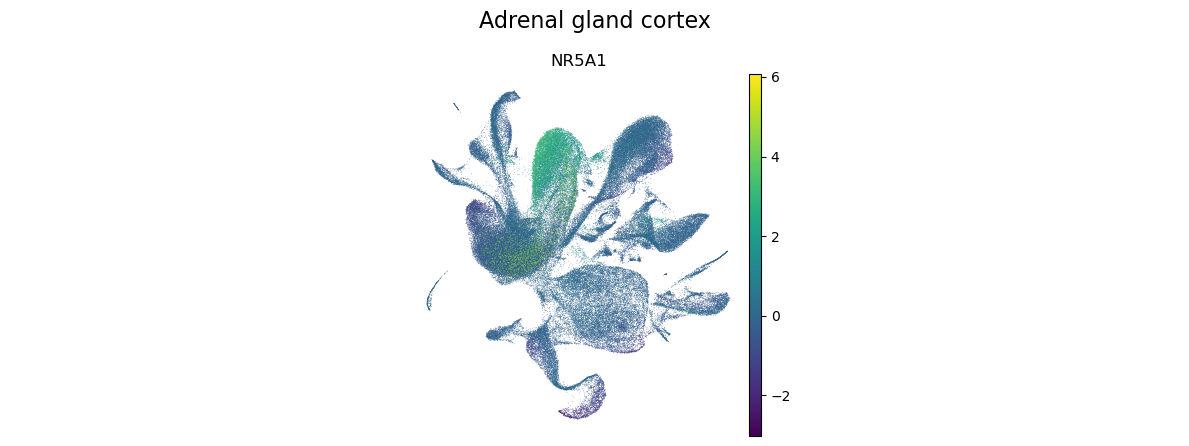

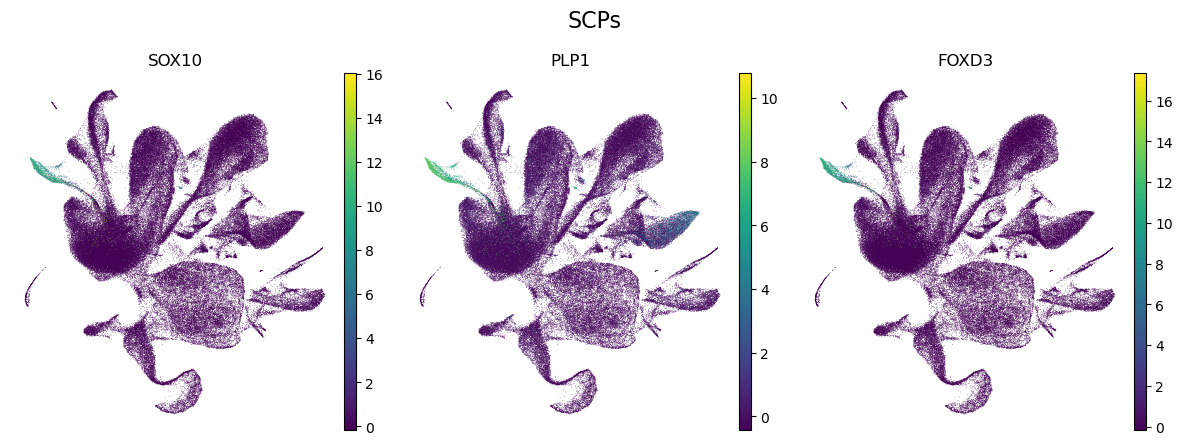

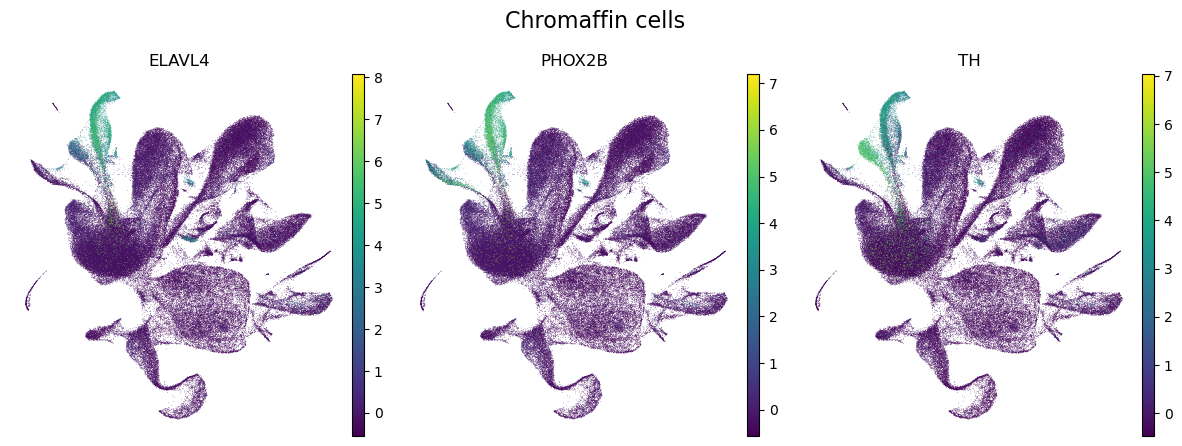

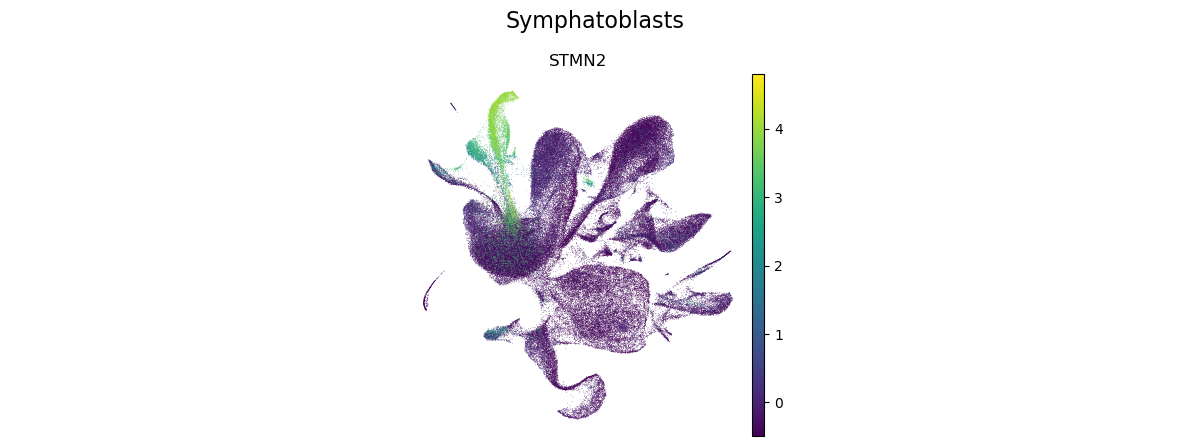

In [ ]:
for category, gene_list in genes.items():
    ncols = 3
    nrows = 1

    figsize = 4

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(3 * figsize, figsize + 0.5),
    )

    axs = axs.flatten()
    
    for idx, gene in enumerate(gene_list):
        # place singular plot in center position
        if len(gene_list) == 1:
            idx = 1
            axs[0].axis("off")
        
        # plot UMAP for the gene
        sc.pl.umap(adata, color=gene, ax=axs[idx], show=False, frameon=False)
        axs[idx].set_title(f"{gene}", fontsize=12)

    # hide unused Axes
    for ax in axs[len(gene_list):]:
        ax.axis("off")

    fig.suptitle(category, fontsize=16)
    fig.tight_layout()
    plt.show()


The above plots do not exhibit clusters as concise as those presented in the paper, likely due to differences in preprocessing methods. Nevertheless, some clusters, such as endothelium, liver, and kidney, are very similar to those identified in the study. Others, however, are less well-recovered. Notably, SCPs, chromaffin cells, and sympathoblasts maintain a similar spatial arrangement, occupying a prominent position in the top-left area of the plot which is too covered by the Leiden clusters also capture some of the patterns observed in the paper.

### Differentially Expressed Genes

In [44]:
# https://github.com/scverse/scverse-tutorials/blob/main/docs/notebooks/basic-scrna-tutorial.ipynb

In [ ]:
# top 5 differential expressed genes per cluster
sc.tl.rank_genes_groups(adata, 'leiden', )

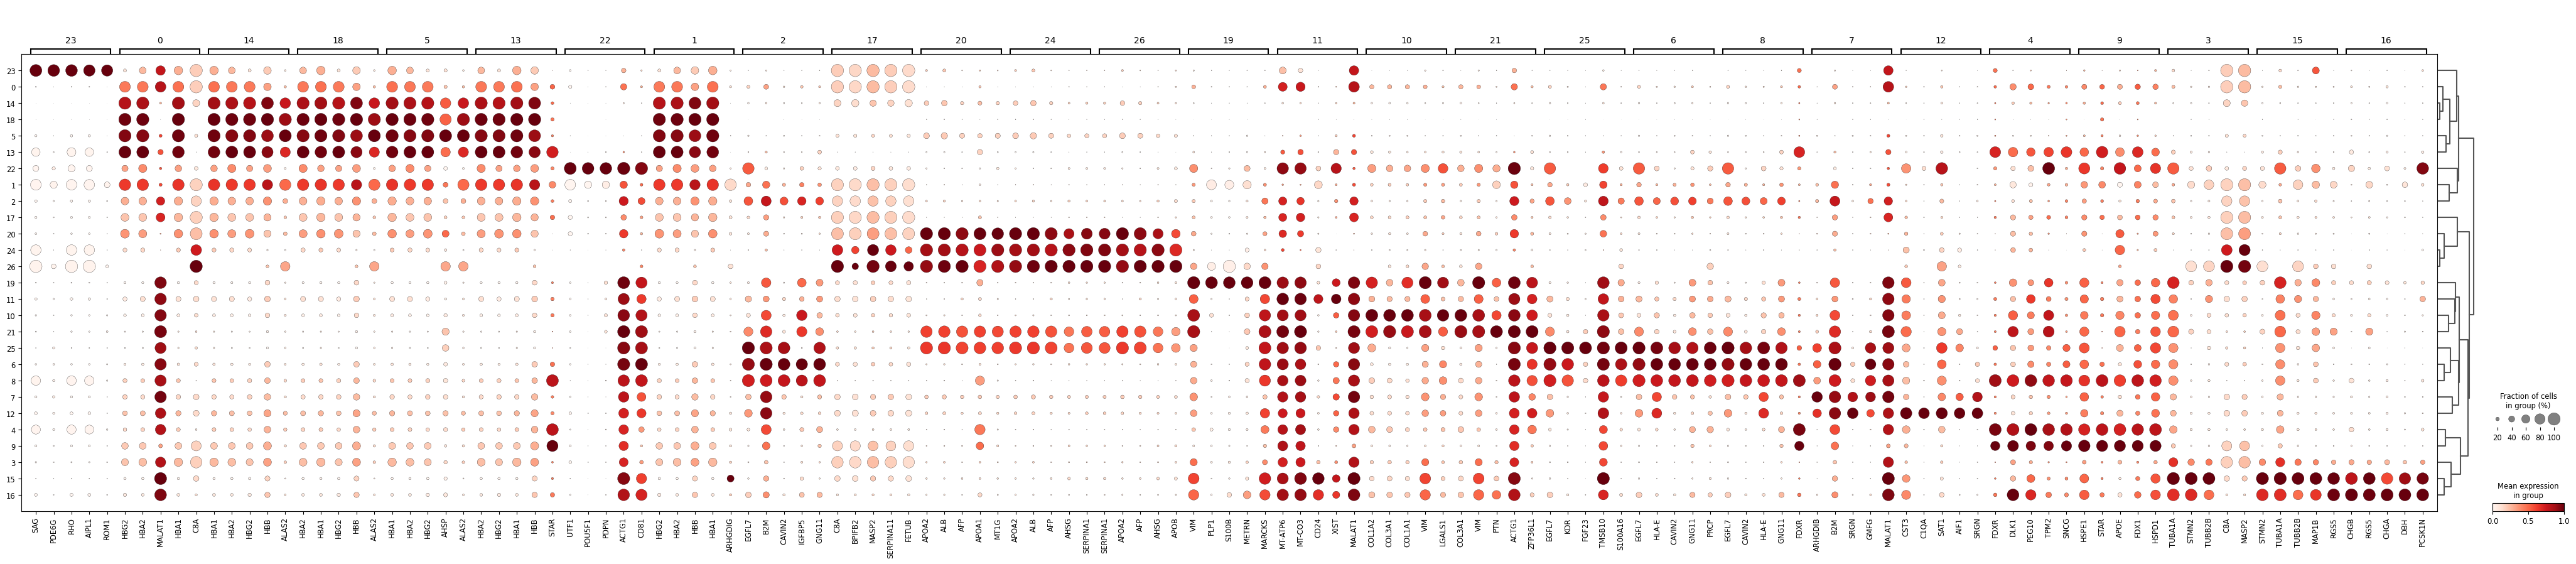

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

The differentially expressed genes reveal a clear grouping of cells. However, the clustering appears overly fine-grained. Given more time, I would explore leveraging the dendrogram and manual annotation to merge clusters with nearly identical signatures, further refining their annotation to correspond with specific cell types.

In [70]:
# write
adata.write_h5ad('./data/merged/cleaned_w_cluster.h5ad')

## Focused Analysis

This section deals with Tasks 5 and 6.

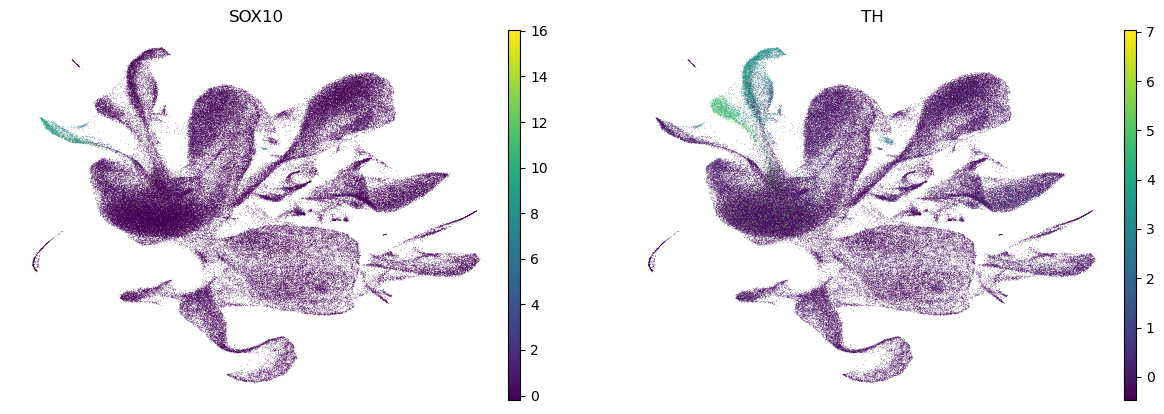

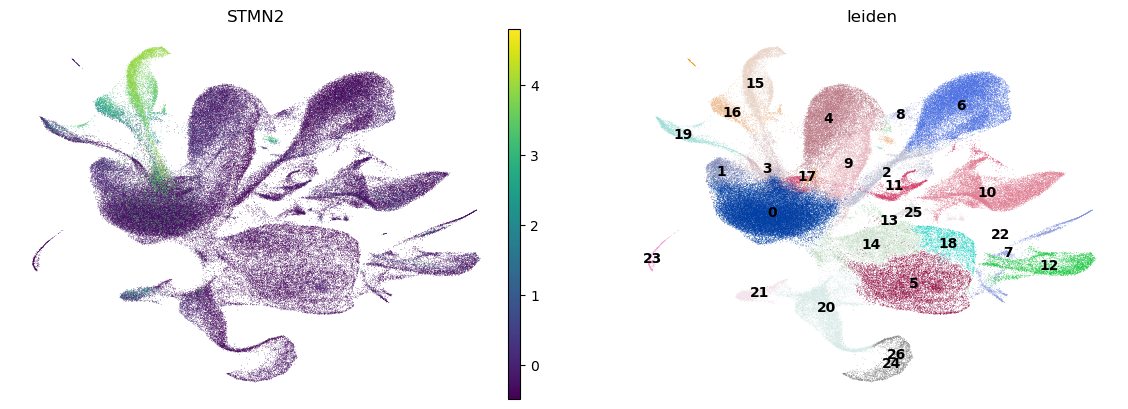

In [12]:
# plot leiden clusters and SOX10 ELAVL4 and STMN2
sc.pl.umap(adata, color=['SOX10', 'TH'], use_raw=False, legend_loc='on data', frameon=False)
sc.pl.umap(adata, color=['STMN2', 'leiden'], use_raw=False, legend_loc='on data', frameon=False)


Looking at some of the marker genes SOX10, TH, and STMN2, we can identify the corresponding SCP, Symphatoblast and Chromaffin cell clusters with the indices 3, 15, 16, and 19.

In [13]:
# confine analysis on clusters 15, 16, 19
adata = adata[adata.obs['leiden'].isin(['3', '15', '16', '19'])]

As stated in the paper, the sample W12E2 biopsy 1, corresponding to sample id 036 was removed, as it is an extra-adrenal sample. Any observations from this sample can be assumed to be "False Positives" in these adrenal cell clusters.

This leaves us with a total of 11,766 cells for this analysis.

In [14]:
adata = adata[adata.obs['sample'] != '036']
adata.shape

(11766, 2000)

In the face of limited time available I omitted the further processing steps of:
- removing cells with a scrublet score of <0.2
- identifying genes that strongly correlate to the cell cylce markers MKI67, TOP2A, and TUBB4B
- remove STAR gene cells

### Re-clustering

In this section, my objective was to closely reproduce the results from the paper. However, differences in preprocessing led to variations in cell counts and a less concise UMAP representation, which I interpreted as potential contamination in the clustering. To address this, I performed re-clustering and iteratively removed clusters until I achieved a single, connected population of cells.

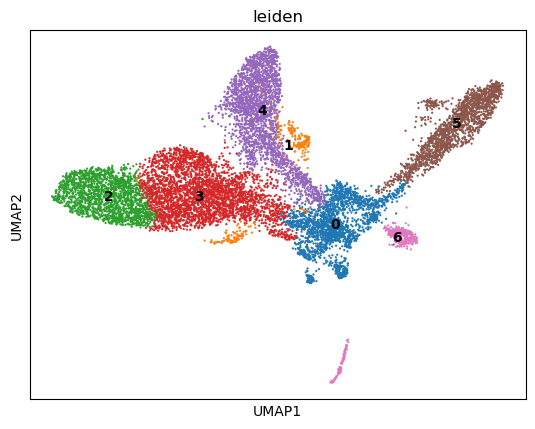

In [15]:
# re-cluster
sc.pp.neighbors(adata, n_neighbors=200, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.3)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

In [16]:
# remove 11 12 13 since they are disconnected
adata = adata[~adata.obs['leiden'].isin(['6'])]

In [17]:
# re-run PCA, neighbors, UMAP
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=200, n_pcs=15)
sc.tl.umap(adata)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


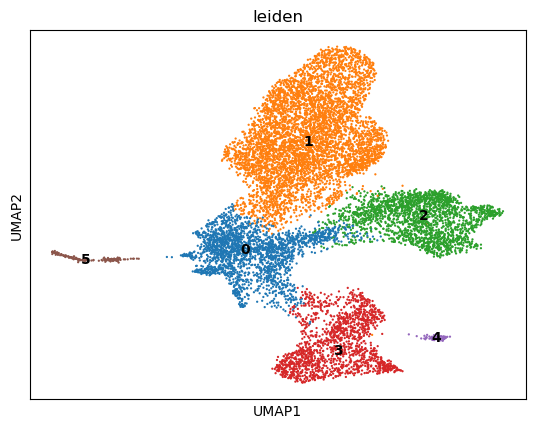

In [18]:
# re-run Leiden and plot
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

In [19]:
# remove 11 12 13 since they are disconnected
adata = adata[~adata.obs['leiden'].isin(['5', '4'])]

In [20]:
# re-run Leiden and plot
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


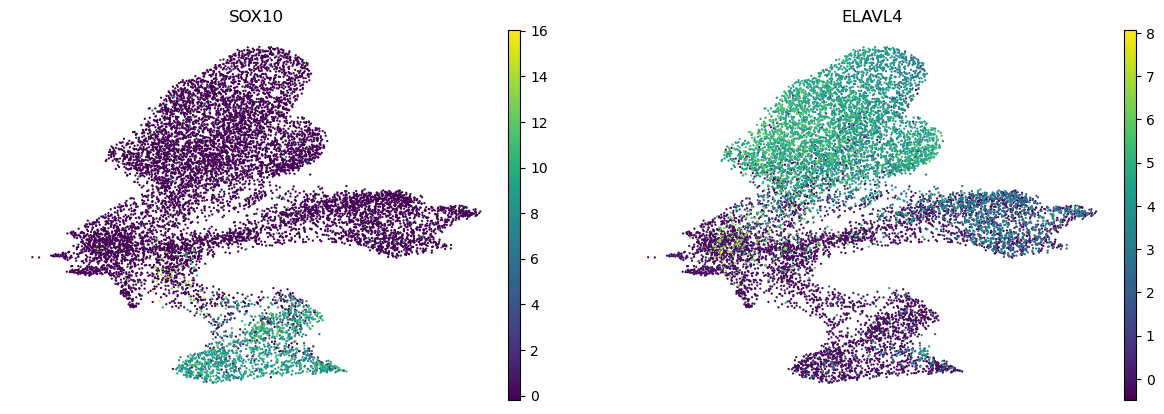

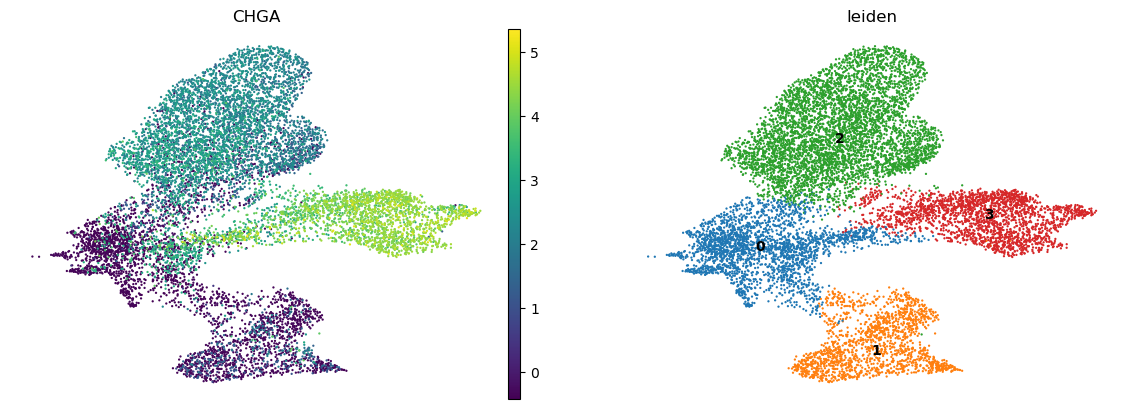

In [21]:
# visualize SOX10 ELAVL4 and CHGA
sc.pl.umap(adata, color=['SOX10', 'ELAVL4'], use_raw=False, frameon=False)
sc.pl.umap(adata, color=['CHGA', 'leiden'], use_raw=False, legend_loc='on data', frameon=False)

The final clustering of the reduced data set reveals four clusters. Based on the marker gene expressions we can conclude that
- Cluster 1 (orange) corresponds to SCPs and therefore is the root cluster for the following trajectory analysis
- Cluster 0 seems to be an intermediate state in the differentiation process
- Cluster 3 (red) corresponds to Chromaffin cells
- Cluster 2 (green) corresponds to Symphatoblasts

In [22]:
# replcae cluster labels

adata.obs['leiden_annotated'] = adata.obs['leiden'].replace({
    '0': 'Intermediate',
    '1': 'SCPs',
    '2': 'Symphatoblasts',
    '3': 'Chromaffin cells'
})

/tmp/ipykernel_169082/2122177542.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['leiden_annotated'] = adata.obs['leiden'].replace({


### Trajectory Analysis

For this analysis, I chose the Partition-based Graph Abstraction (PAGA) trajectory approach. My choice was informed by prior experience using PAGA in a previous analysis, as well as my familiarity with the tool through a friend who worked in the Theis Lab, which developed it.

Although I initially attempted to use scVelo, I encountered compatibility issues with the data at hand. As a result, I opted for PAGA, which was not only a robust alternative but also conveniently integrated into the ScanPy package.

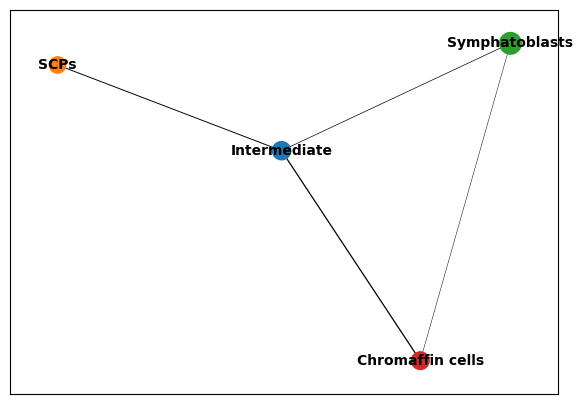

In [23]:
# trajectory analysis
sc.tl.paga(adata, groups='leiden_annotated')
sc.pl.paga(adata, threshold=0.03, show=True)

The plot illustrates that SCPs can differentiate into chromaffin cells and sympathoblasts via a direct pathway that passes through an intermediate state. Additionally, it reveals that chromaffin cells and sympathoblasts are capable of transitioning into one another, consistent with the findings described in the paper linked to the assignment.

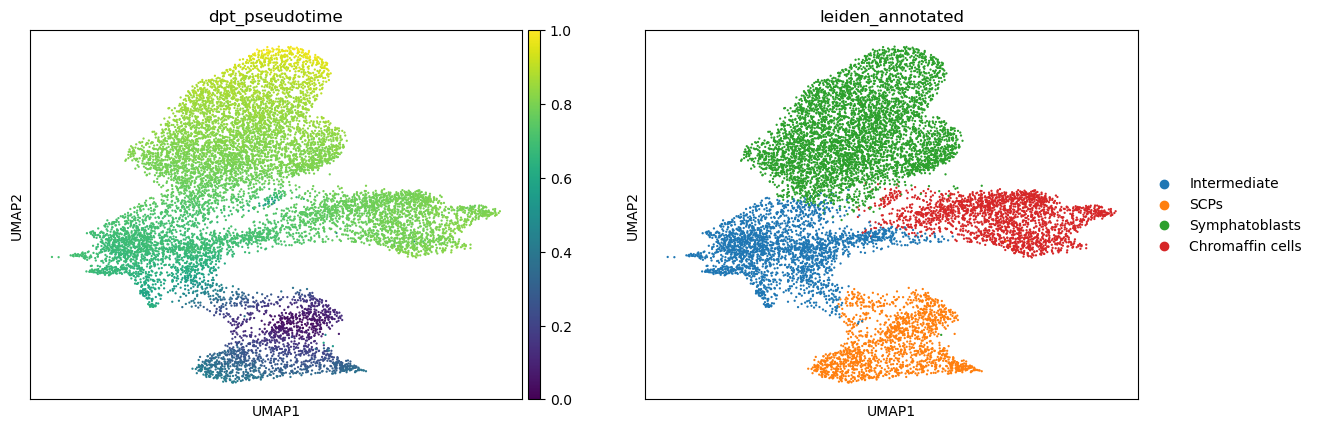

In [24]:
# https://nbisweden.github.io/workshop-scRNAseq/labs/scanpy/scanpy_07_trajectory.html#gene-changes

# Choose a root cell or cluster
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_annotated'] == 'SCPs')[0]

# Compute diffusion pseudotime
sc.tl.dpt(adata)

# Plot pseudotime
sc.pl.umap(adata, color=['dpt_pseudotime', 'leiden_annotated'], show=True)


In [25]:
# Define paths
paths = [
    ('SCPs->Symphatoblasts', ['SCPs', 'Intermediate', 'Symphatoblasts']),
    ('SCPs->Chromaffin cells', ['SCPs', 'Intermediate', 'Chromaffin cells']),
    ('SCPs->Symp->Chromaffin', ['SCPs', 'Intermediate', 'Symphatoblasts', 'Chromaffin cells']),
    ('SCPs->Chromaffin->Symp', ['SCPs', 'Intermediate', 'Chromaffin cells', 'Symphatoblasts']),
]

adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [26]:
gene_names = ['SOX10', 'PLP1', 'FOXD3', 'ELAVL4', 'PRPH', 'ISL1', 'CHGA', 'PNMT', 'STMN2']

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1283: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1332: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


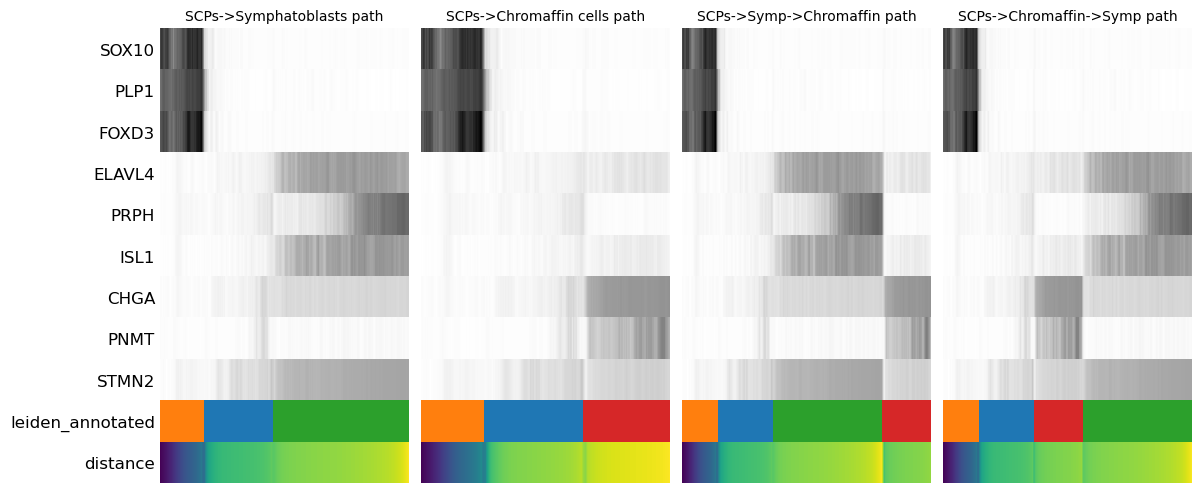

In [27]:
_, axs = plt.subplots(ncols=4, figsize=(12, 6), gridspec_kw={
                     'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(
        adata=adata, 
        nodes=path, 
        keys=gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=100,
        annotations=['distance'],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map='Greys',
        # groups_key='annot',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        use_raw=False,
        show=False)

plt.show()

These findings suggest that, in addition to the trajectories from SCPs to sympathoblasts and chromaffin cells individually (as shown in the two leftmost plots), there is a notable connection between sympathoblasts and chromaffin cells. While the directionality of these transitions remains uncertain, the authors of the referenced paper propose that the primary direction is from sympathoblasts to chromaffin cells. However, the current plot indicates smoother gene expression transitions from chromaffin cells to sympathoblasts. Furthermore, the pseudotime analysis supports this observation, highlighting a more gradual transition from chromaffin cells to sympathoblasts.

In [ ]:
# write final data
adata.write_h5ad('./data/merged/final.h5ad')